<a href="https://colab.research.google.com/github/levmert/Alpha-Vantage-Pandas/blob/master/examples/colab/bert_experts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2020 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
#@title Copyright 2020 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/hub/tutorials/bert_experts"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/bert_experts.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/hub/blob/master/examples/colab/bert_experts.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/hub/examples/colab/bert_experts.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/s?q=experts%2Fbert"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub models</a>
  </td>
</table>

# BERT Experts from TF-Hub

This colab demonstrates how to:
* Load BERT models from [TensorFlow Hub](https://tfhub.dev) that have been trained on different tasks including MNLI, SQuAD, and PubMed
* Use a matching preprocessing model to tokenize raw text and convert it to ids
* Generate the pooled and sequence output from the token input ids using the loaded model
* Look at the semantic similarity of the pooled outputs of different sentences

#### Note: This colab should be run with a GPU runtime

## Set up and imports

In [1]:
!pip install --quiet "tensorflow-text==2.11.*"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 60.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 40.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 37.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 kB 38.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 74.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 52.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-datasets 4.9.2 requires protobuf>=3.20, but you have protobuf 3.19.6 which is incompatible.
tensorflow-metadata 1.13.1 requires protobuf<5,>=3.20.3, but you have protobuf 3.19.

In [2]:
import seaborn as sns
from sklearn.metrics import pairwise

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text  # Imports TF ops for preprocessing.

In [3]:
#@title Configure the model { run: "auto" }
BERT_MODEL = "https://tfhub.dev/google/experts/bert/wiki_books/2" # @param {type: "string"} ["https://tfhub.dev/google/experts/bert/wiki_books/2", "https://tfhub.dev/google/experts/bert/wiki_books/mnli/2", "https://tfhub.dev/google/experts/bert/wiki_books/qnli/2", "https://tfhub.dev/google/experts/bert/wiki_books/qqp/2", "https://tfhub.dev/google/experts/bert/wiki_books/squad2/2", "https://tfhub.dev/google/experts/bert/wiki_books/sst2/2",  "https://tfhub.dev/google/experts/bert/pubmed/2", "https://tfhub.dev/google/experts/bert/pubmed/squad2/2"]
# Preprocessing must match the model, but all the above use the same.
PREPROCESS_MODEL = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

## Sentences

Let's take some sentences from Wikipedia to run through model

In [4]:
sentences = [
  "Here We Go Then, You And I is a 1999 album by Norwegian pop artist Morten Abel. It was Abel's second CD as a solo artist.",
  "The album went straight to number one on the Norwegian album chart, and sold to double platinum.",
  "Among the singles released from the album were the songs \"Be My Lover\" and \"Hard To Stay Awake\".",
  "Riccardo Zegna is an Italian jazz musician.",
  "Rajko Maksimović is a composer, writer, and music pedagogue.",
  "One of the most significant Serbian composers of our time, Maksimović has been and remains active in creating works for different ensembles.",
  "Ceylon spinach is a common name for several plants and may refer to: Basella alba Talinum fruticosum",
  "A solar eclipse occurs when the Moon passes between Earth and the Sun, thereby totally or partly obscuring the image of the Sun for a viewer on Earth.",
  "A partial solar eclipse occurs in the polar regions of the Earth when the center of the Moon's shadow misses the Earth.",
]

## Run the model

We'll load the BERT model from TF-Hub, tokenize our sentences using the matching preprocessing model from TF-Hub, then feed in the tokenized sentences to the model. To keep this colab fast and simple, we recommend running on GPU.

Go to **Runtime** → **Change runtime type** to make sure that **GPU** is selected

In [5]:
preprocess = hub.load(PREPROCESS_MODEL)
bert = hub.load(BERT_MODEL)
inputs = preprocess(sentences)
outputs = bert(inputs)

In [6]:
print("Sentences:")
print(sentences)

print("\nBERT inputs:")
print(inputs)

print("\nPooled embeddings:")
print(outputs["pooled_output"])

print("\nPer token embeddings:")
print(outputs["sequence_output"])

Sentences:
["Here We Go Then, You And I is a 1999 album by Norwegian pop artist Morten Abel. It was Abel's second CD as a solo artist.", 'The album went straight to number one on the Norwegian album chart, and sold to double platinum.', 'Among the singles released from the album were the songs "Be My Lover" and "Hard To Stay Awake".', 'Riccardo Zegna is an Italian jazz musician.', 'Rajko Maksimović is a composer, writer, and music pedagogue.', 'One of the most significant Serbian composers of our time, Maksimović has been and remains active in creating works for different ensembles.', 'Ceylon spinach is a common name for several plants and may refer to: Basella alba Talinum fruticosum', 'A solar eclipse occurs when the Moon passes between Earth and the Sun, thereby totally or partly obscuring the image of the Sun for a viewer on Earth.', "A partial solar eclipse occurs in the polar regions of the Earth when the center of the Moon's shadow misses the Earth."]

BERT inputs:
{'input_word_

## Semantic similarity

Now let's take a look at the `pooled_output` embeddings of our sentences and compare how similar they are across sentences.

In [8]:
#@title Helper functions

def plot_similarity(features, labels):
  """Plot a similarity matrix of the embeddings."""
  cos_sim = pairwise.cosine_similarity(features)
  sns.set(font_scale=1.2)
  cbar_kws=dict(use_gridspec=False, location="left")
  g = sns.heatmap(
      cos_sim, xticklabels=labels, yticklabels=labels,
      vmin=0, vmax=1, cmap="Blues", cbar_kws=cbar_kws)
  g.tick_params(labelright=True, labelleft=False)
  g.set_yticklabels(labels, rotation=0)
  g.set_title("Semantic Textual Similarity")

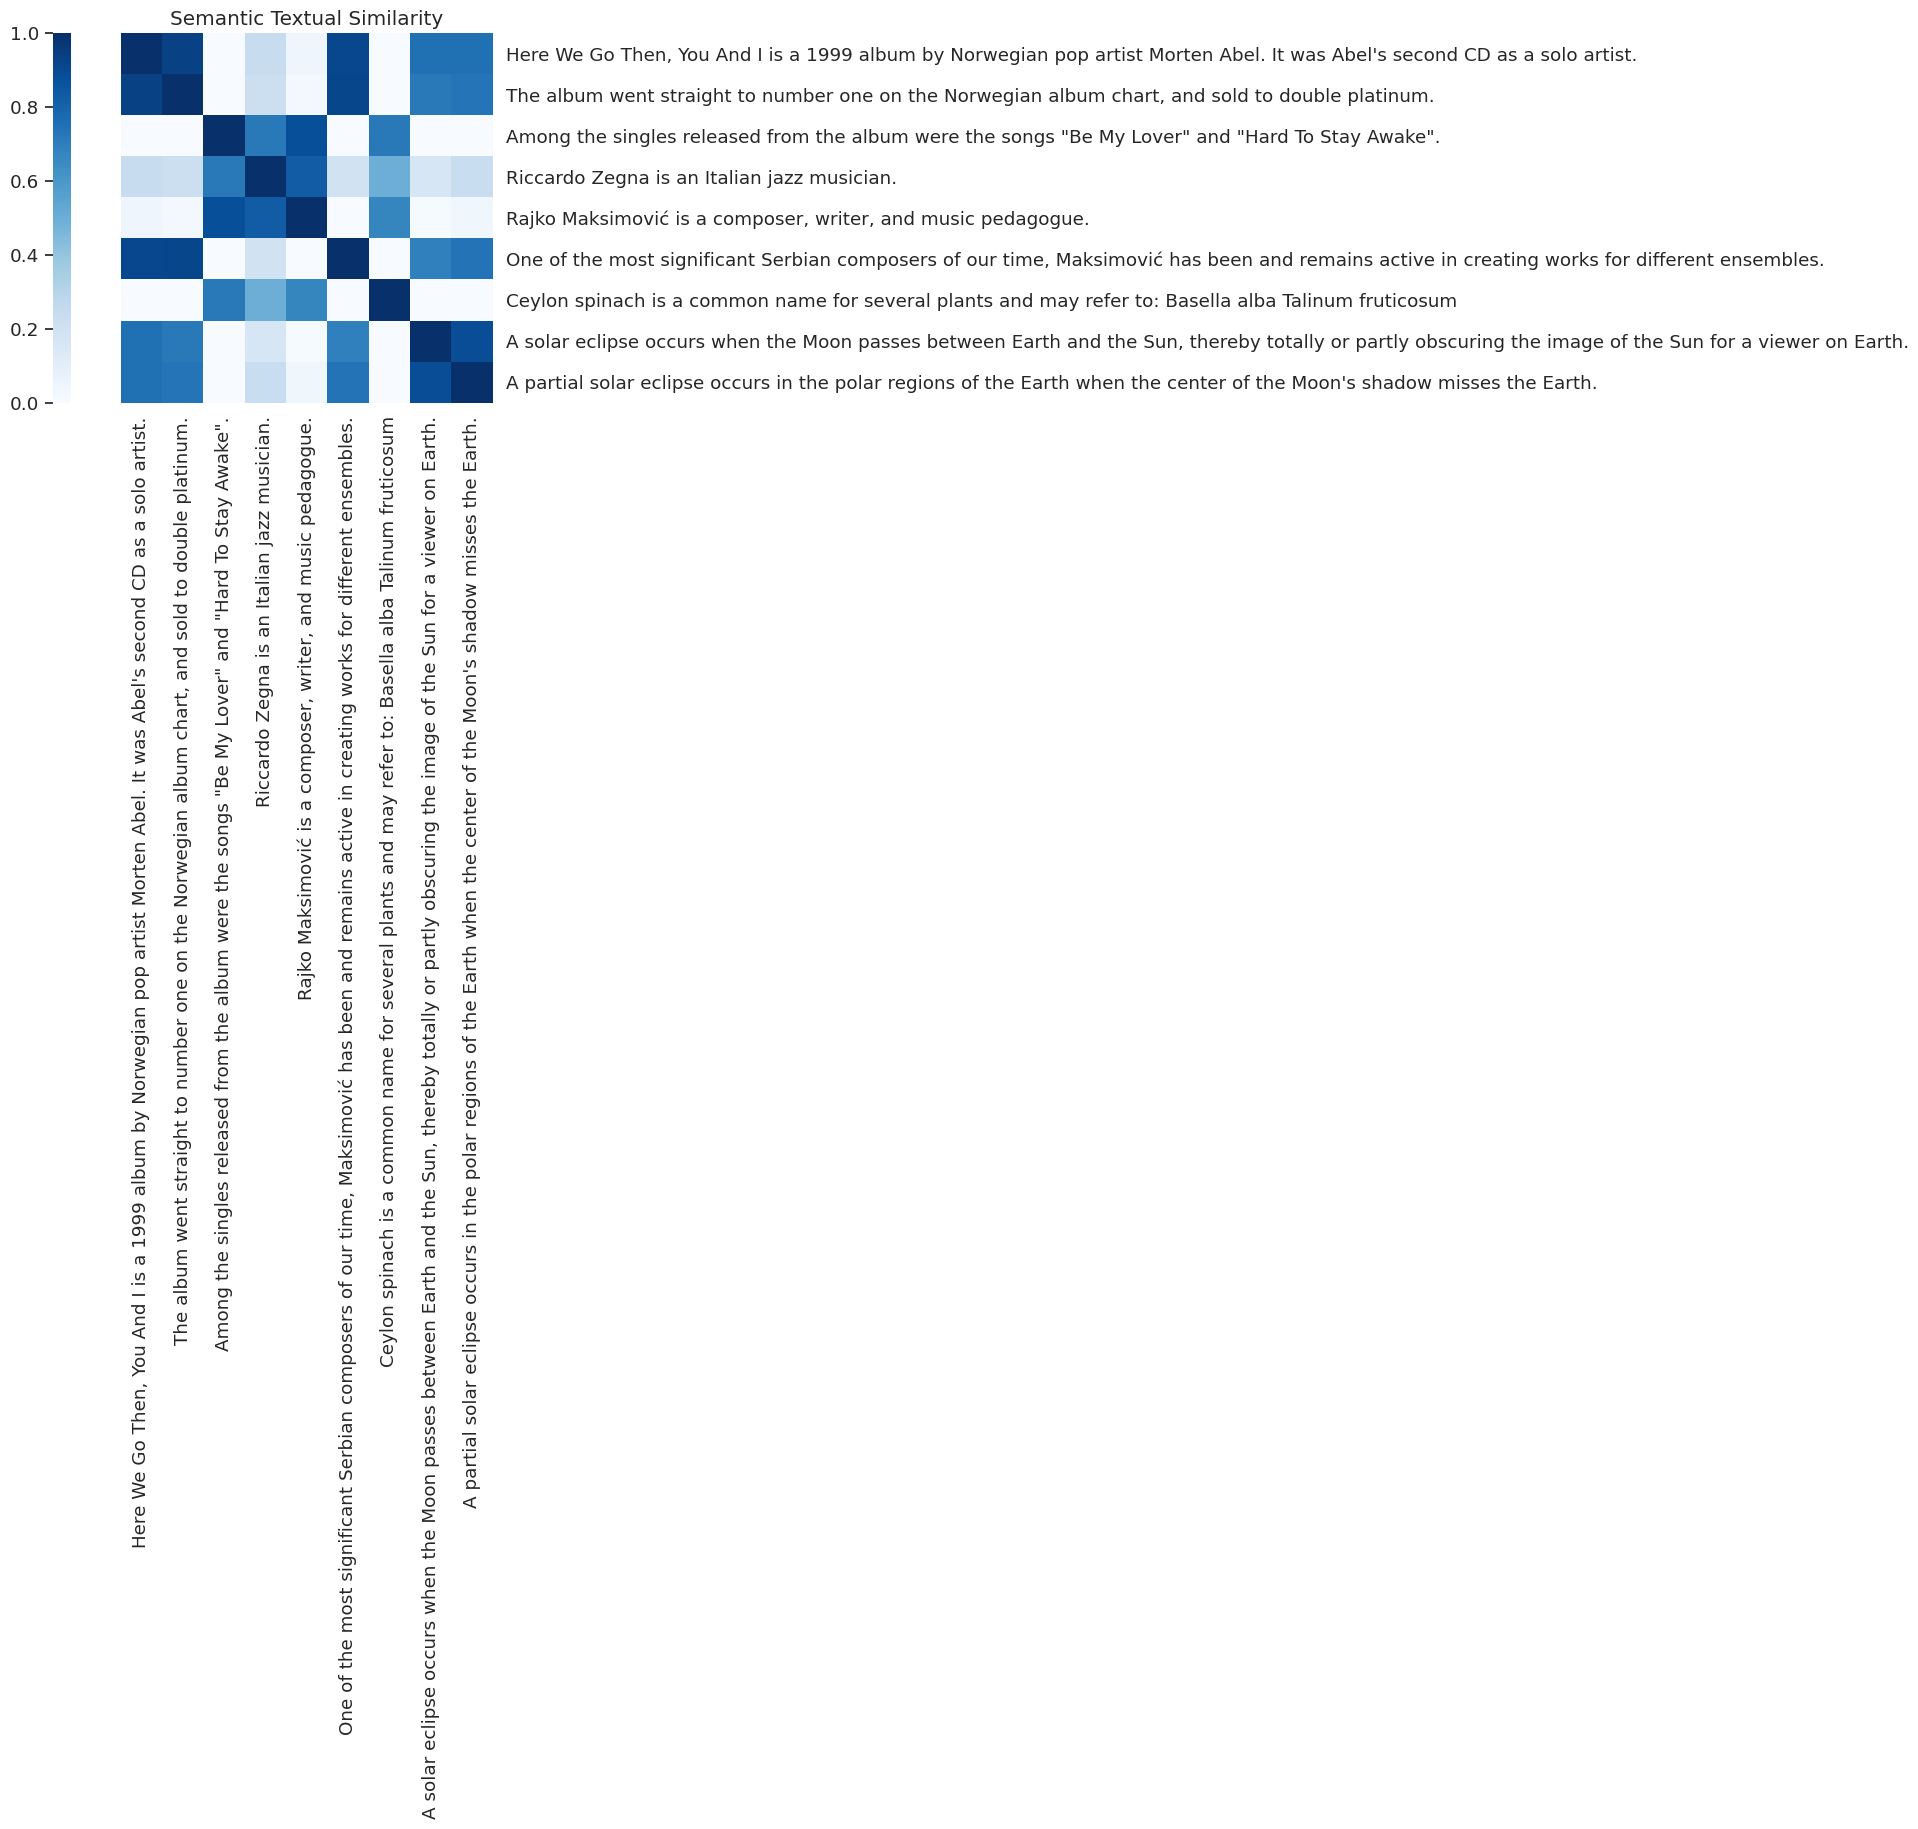

In [9]:
plot_similarity(outputs["pooled_output"], sentences)

## Learn more

* Find more BERT models on [TensorFlow Hub](https://tfhub.dev)
* This notebook demonstrates simple inference with BERT, you can find a more advanced tutorial about fine-tuning BERT at [tensorflow.org/official_models/fine_tuning_bert](https://www.tensorflow.org/official_models/fine_tuning_bert)
* We used just one GPU chip to run the model, you can learn more about how to load models using tf.distribute at [tensorflow.org/tutorials/distribute/save_and_load](https://www.tensorflow.org/tutorials/distribute/save_and_load)